In [1]:
# dependency installation

!pip install pywaffle
!pip install hdbscan

     |████████████████████████████████| 532kB 4.9MB/s 
     |████████████████████████████████| 4.9MB 4.9MB/s 
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - done
    Preparing wheel metadata ... - done
  Created wheel for hdbscan: filename=hdbscan-0.8.23-cp36-cp36m-linux_x86_64.whl size=2471303 sha256=69bed03e47b591cd9e7aca1827f723efb7afc3af7bf05012020bf80a4bcca78b
  Stored in directory: /tmp/.cache/pip/wheels/1e/2a/69/0cdd5414624312666718f7526b0ab39cad65cea1c1b3892768
Successfully built hdbscan


In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from pywaffle import Waffle
from hdbscan import HDBSCAN
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency

pd.options.display.max_columns = 300

%matplotlib inline

In [3]:
path = "/kaggle/input/kaggle-survey-2019/multiple_choice_responses.csv"
kaggle_df = pd.read_csv(path, low_memory=False)

# What does it mean to work for big companies vs early stage startup as a data scientist?

## Are you a fresh graduate who is looking for his/her first data scientist job after school? Or are you a seasoned data scientist who is considering a career move to take new adventures? You might be on the fence between big companies and small startups. If so, this analysis might be a good reference for you!

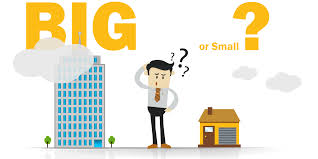

When googling "difference between working for large company vs startup as data scientist", you will find a lot of discussions in forums or blogs, e.g. [1](https://blog.madkudu.com/startup-vs-bigco-best-career-option-data-scientists/) or [2](https://analyticsindiamag.com/should-you-start-your-data-science-career-with-big-tech-companies-or-startups/). From those you might get some impressions on how it looks like working for such two types of companies. Besides listening to other people's anecdotal stories, Kaggle provides us an opportunity to find these insights from a survey data Kagglers filled in.

This is the annual survey Kaggle conduct that presents a comprehensive industry-wide view of the state of ML and data science. It covers the topics from salary, tooling, education to the main activities at work, data science development stage and common ML algorithms etc. Therefore, through analzing the data could help us better answer the questions:

1. What are the general qualifications of big companies and small companies?
2. What can you expect from big companies and early stage startups?

In the following analysis, I am going to break down the two topics above and discuss the pros and cons of working for two different types of companies as a data scientist. First of all, in order to conduct my analysis to answer the two topics above, I would like to set my analysis target. Afterwards, I will present detailed analysis to answer those two questions. In the end, I would like to summarize my analyze and give some recommendations for which one might be a better fit for you.

# 1. Which groups did I target in this analysis?

In this survey, there are five categories of company size, including:
    - small companies (0-49 employees)
    - growing startups (50-249 employees)
    - well-developed startups or small-sized companies (250-999 employees)
    - medium-sized companies (1000-9999 employees)
    - giant companies (> 10000 employees).

After visualizing the number of respondents in each size of company, we can see that the two cases where large firms (with > 10000 employees) and early stage startups (0-49 employees) are the only two groups that surpass the average. Therefore, choosing these two groups would guarantee us a good amount of data points. Furthermore, due to the huge discrepancy in company sizes, these two are the most representative ones among all the groups.

Therefore, in further analysis, I will focus on comparing the data between these two groups.

In [4]:
# load subset for data scientists
ds_df = kaggle_df.query("Q5 == 'Data Scientist'").iloc[1:, :]

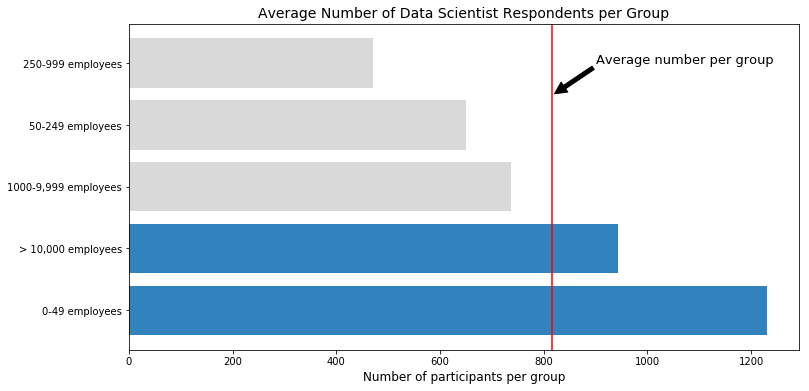

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))

counts = ds_df["Q6"].value_counts()

cmap = plt.get_cmap("tab20c")
ax.barh(counts[:2].index, counts[:2].values, color=cmap([0]))
ax.barh(counts[2:].index, counts[2:].values, color=cmap([19]))

ax.axvline(ds_df.shape[0] / ds_df["Q6"].nunique(), color="r")
ax.annotate("Average number per group", xy=(820, 3.5), 
            xytext=(900, 4), arrowprops=dict(facecolor='black', shrink=0.01), fontsize=13)
ax.set_xlabel("Number of participants per group", fontsize=12)
plt.title("Average Number of Data Scientist Respondents per Group", fontsize=14);

In [6]:
TARGET_COMPANIES = ["0-49 employees", "> 10,000 employees"]
df = ds_df[ds_df["Q6"].isin(TARGET_COMPANIES)]

[STARTUP_NUM, BIG_CORP_NUM] = df.groupby("Q6").size()

In [7]:
# Make a generic function used for transforming survey dataset.
def _normalized_value_counts(df: pd.DataFrame, col: str, reindexed=False) -> pd.DataFrame:
    """Reusable function to get normalized value counts.
    
    Args:
        df: dataset
        col: column name for value count
        reindexed: False or List, default is False. If a list is assigned, will use it in
            reindexing.
            
    Returns:
        DataFrame
    """
    sub_df = df.groupby("Q6")[col].value_counts(normalize=True).unstack("Q6")
    if reindexed:
        return sub_df.reindex(reindexed)
    return sub_df

In [8]:
# Make a customized multi bar plot function to reduce repeated code.
def customized_multi_bar_plot(df: pd.DataFrame, col: str, xticks: list, title: str):
    """Customized multi bar plot with several options for customization."""
    df_bar = _normalized_value_counts(df, col=col)
    (
        df_bar
        .apply(lambda x: x.round(3) * 100)
        .reindex(xticks)
        .plot(kind='bar', colormap="tab20c", figsize=(12, 8))
    )

    plt.xticks(rotation=60)
    plt.grid(axis='y', color="black", alpha=0.5)
    plt.ylabel("Percentage across the group (%)")
    plt.title(title, fontsize=14);

In [9]:
# Make a customized barh plot
def customized_barh(df: pd.DataFrame, ordered_cols: list, colors: list, legend_loc: tuple, title: str):
    """Customized barh plot with several options."""
    fig, ax = plt.subplots(figsize=(20, 2))
    
    for idx, col in enumerate(TARGET_COMPANIES):
        bar_start = 0
        for c, order in zip(colors, ordered_cols):
            value = df.loc[order, col]
            ax.barh(y=col, width=value, height=0.6, left=bar_start, color=c)
            plt.text(bar_start + value/2 - 0.01, idx - 0.1, "{:.0%}".format(value), fontsize=12)
            bar_start += value
    
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    ax.get_xaxis().set_visible(False)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_facecolor("white")
    leg = ax.legend(ordered_cols, loc=legend_loc, fontsize=14)
    plt.title(title, fontsize=18);

In [10]:
def _transform_df_q2(df: pd.DataFrame, col: str, col_name: str) -> pd.DataFrame:
    """Internal dataframe transformation method for data preparation.
    
    Args:
        df: dataset
        col: size of company, either "0-49 employees" or "> 10,000 employees"
    """
    group_size = BIG_CORP_NUM
    if col == "0-49 employees":
        group_size = STARTUP_NUM

    sub_df = (
        df[df["Q6"] == col]
            .groupby("Q1")["Q2"]
            .value_counts()
            .unstack("Q2")
            .fillna(0)
            .apply(lambda x: (x / group_size).round(3) * 100)
    )
    sub_df.columns.name = col_name
    
    return sub_df

In [11]:
def concat_df_bar_plot(df: pd.DataFrame, s: pd.Series):
    """Concatenate data and visualize bar plot after certain data cleaning."""
    concat_df = _normalized_value_counts(pd.concat([df['Q6'], s], axis=1), col="sumed")
    (
        concat_df
        .round(3)
        .fillna(0) * 100 
    ).plot(kind='bar', figsize=(20, 5), cmap="tab20c")

In [12]:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# 2. Detailed Analysis

In this section, I will present my analysis for 1) the qualifications for big companies and early stage startups 2) What can you expect from big companies and early stage startups?


## 2.1 What are the general qualifications of big companies and small companies?

In this part, I would like to discuss the following variables and illustrate how they vary in big companies vs early-stage start-ups:
* Education backgroundu
* Years of experience in ML and coding
* Common tooling to use at work
* Common programming languages used at work
* General information about algorithms, frameworks, cloud platforms used at work

## 2.1.1 Education background

As deep learning techniques are becoming more and more popular, we would expect the trend that some companies might want to hire data scientists with PhD background. However, from the survey data it turns out that Master is still the main force. This might suggest that from lab to industry, there is still lots of rooms to improve in appyling advanced models in production.

#### Key takeways:

1. The distribution of differnet education backgrounds of data scientists in giant companies and startups is similar.
2. **Master (~50% and ~55%) and Bachelor (~25% and ~22%)** are still main forces in data scientists' education background.
3. **Small startups have larger portion (~7%) of data scientists who did not get degree or only have professional degree**. While giant companies seem to be more strict on education background, with only 3% data scientists in big firms do not have at least a Bachelor's degree.

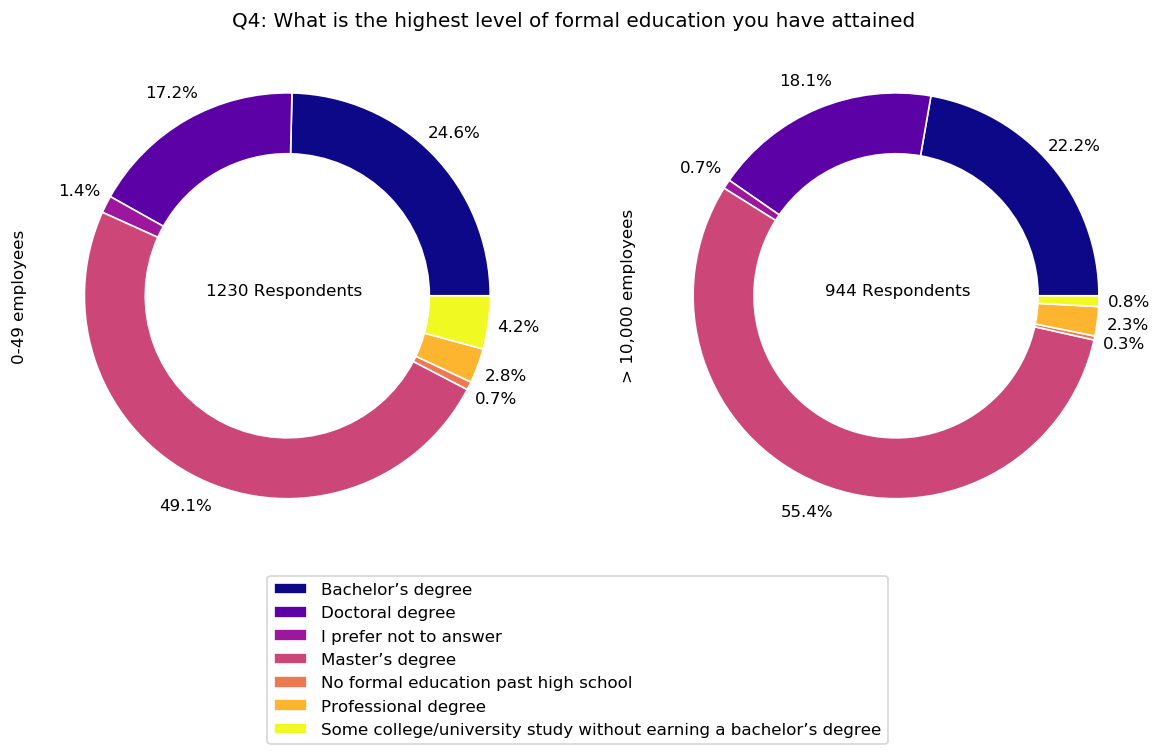

In [13]:
q4 = _normalized_value_counts(df, col="Q4")
cats = q4.index

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12), dpi=120)

q4.plot(kind="pie", colormap="plasma", labels=None, subplots=True, legend=False,
        ax=ax, autopct=lambda x: "{:.1%}".format(x/100),pctdistance=1.15,
        wedgeprops=dict(width=0.3, edgecolor='white'))

plt.suptitle("Q4: What is the highest level of formal education you have attained", y=0.7)
plt.text(-3.4, 0, f"{STARTUP_NUM} Respondents")
plt.text(-0.35, -0, f"{BIG_CORP_NUM} Respondents")
plt.legend(cats, loc='lower right', bbox_to_anchor=(0, -0.4, 0.5, 1));

## 2.1.2 Years of experience

These are about the experience in utilizing machine learning methods and writing code to analyze data. Of course, longer years of experience does not necessarily represent better skills, but it can at least show some reference and the levels of your peers.

#### Key takeaways:
1. Generally, **big companies have more experienced data scientists in percentage**, while early stage startups accept relatively more entry level data scientists.
2. Even machine learning has been popular for years, **data scientists having 1-2 years of ML methods take up the biggest percentage, both in big firms and startups**. Therefore, we might say ML is still in its early stage of development.
3. There are around **45% of data scientists in small startups have less than 2 years of using code to analyze data**, while this number is around **25% in large companies**. Therefore, for data scientists, knowing how to write code to analyze data could be very helpful, especially for those who are at their early career stage to stand out from others.

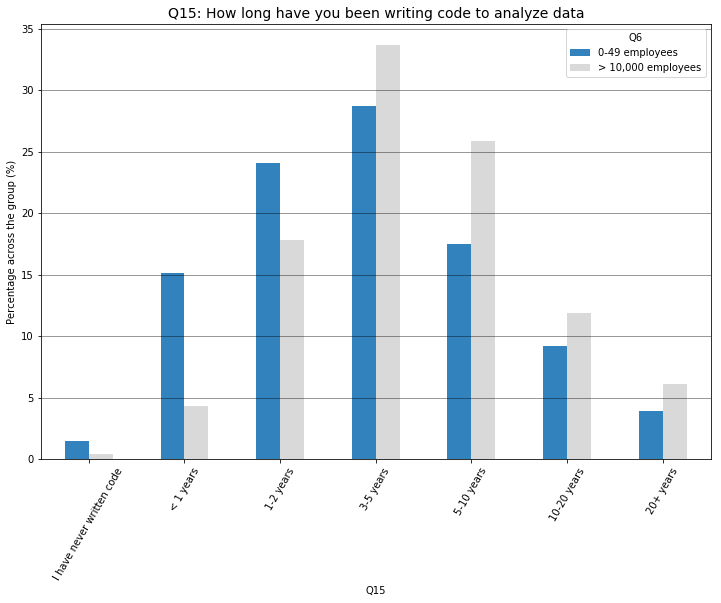

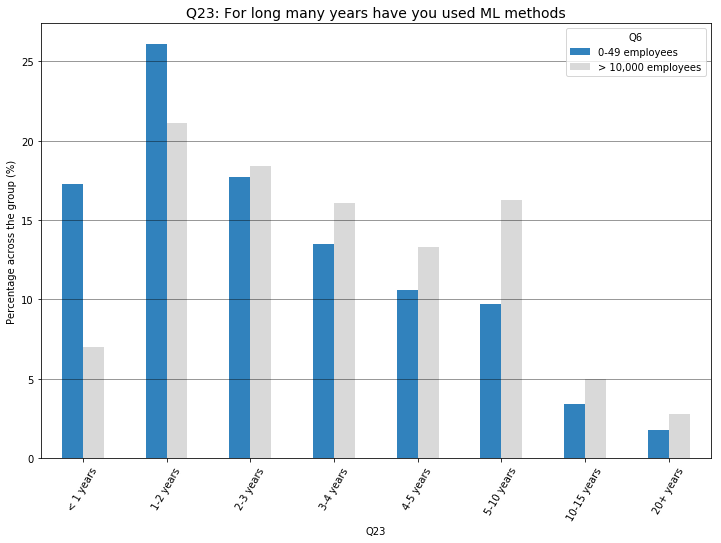

In [14]:
# Question 15
year_idx = ["I have never written code", "< 1 years", "1-2 years", "3-5 years", 
            "5-10 years", "10-20 years", "20+ years"]

customized_multi_bar_plot(df, col="Q15", xticks=year_idx, 
                          title="Q15: How long have you been writing code to analyze data")

# Question 23
year_idx = ["< 1 years", "1-2 years", "2-3 years", "3-4 years", "4-5 years", 
            "5-10 years", "10-15 years", "20+ years"]

customized_multi_bar_plot(df, col="Q23", xticks=year_idx, 
                          title="Q23: For long many years have you used ML methods")

## 2.1.3 Tooling

Another important aspect that we would like to know is the difference of tools data scientists use at work between early stage startups and big firms.

#### Key takeaways:
1. Local development environment is still the majority, with nearly **70% of companies use local development environment on a regular basis** in both groups.
2. Cloud is catching up. It is the second on the list and take up more percentages than traditional statistical softwares.
3. **Startups like Excel and Google Sheets while big companies like SPSS and SAS more**. It is quite understandable because tools like SAS are usually made for big enterprises.

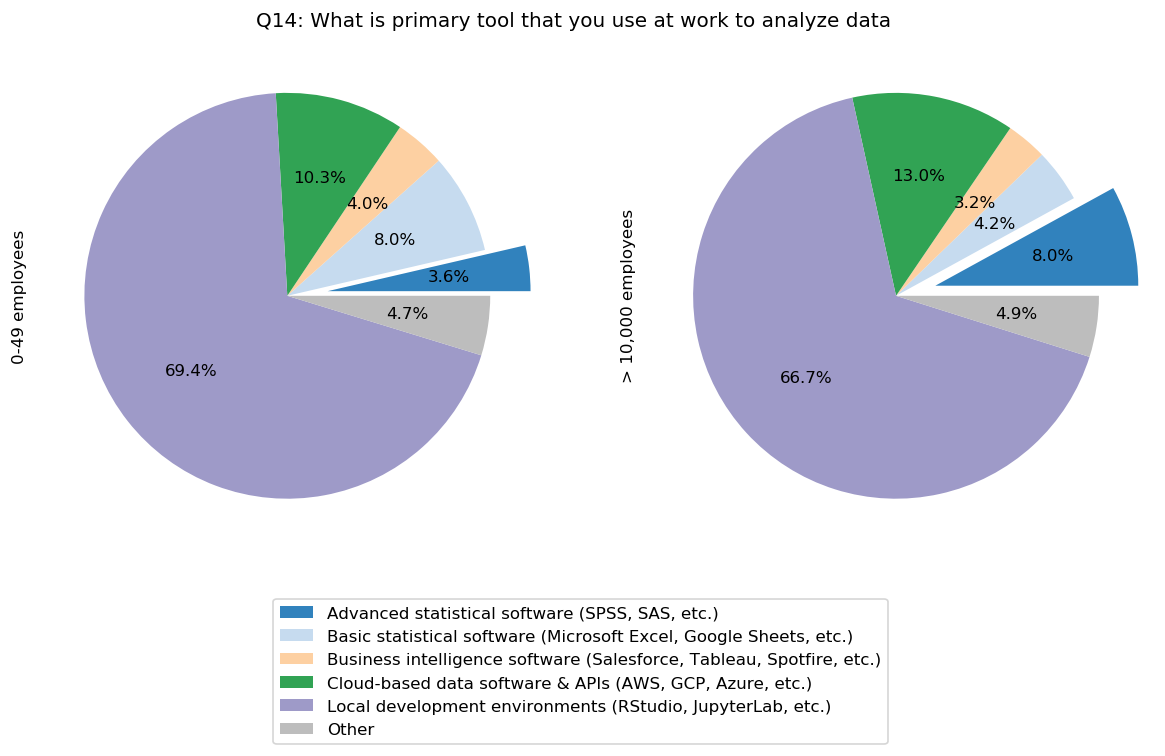

In [15]:
# Question 14
q14 = _normalized_value_counts(df, "Q14")
cats = q14.index
explode=[0.2, 0, 0, 0,0, 0]
cmap = plt.get_cmap("tab20c")
colors = cmap(np.array([0, 3, 7, 8, 13, 18]))

fig, ax = plt.subplots(figsize=(12, 12), dpi=120)

q14.plot(kind='pie', subplots=True, ax=ax, legend=False,
         figsize=(12, 12),
         colors=colors, 
         explode=[0.2, 0, 0, 0, 0, 0],
         autopct=lambda x: "{:.1%}".format(x / 100), labels=None)

plt.legend(cats, loc='lower right', bbox_to_anchor=(0, -0.4, 0.5, 1))
plt.suptitle("Q14: What is primary tool that you use at work to analyze data", y=0.7);

## 2.1.4 Programming languages

After knowing the main tool data scientists used at work, it is also helpful to learn what are the main programming languages they use.

Note: Those respondents who did not select any and left all options blank in this question are filtered out.

#### Key takeaways:
1. **Python and SQL** are key programming languages for data scientists to use at work.
2. Data scientists in big firms tend to use more diversed programming languages at work, with more than **45% of them use at least three languages at work**.
3. **Bash is more popularly used in big firms**, ~30% data scientists in big companies use Bash, while only ~15% in small startups.
4. Data scientists are **barely in favor of C++ and JavaScript**.

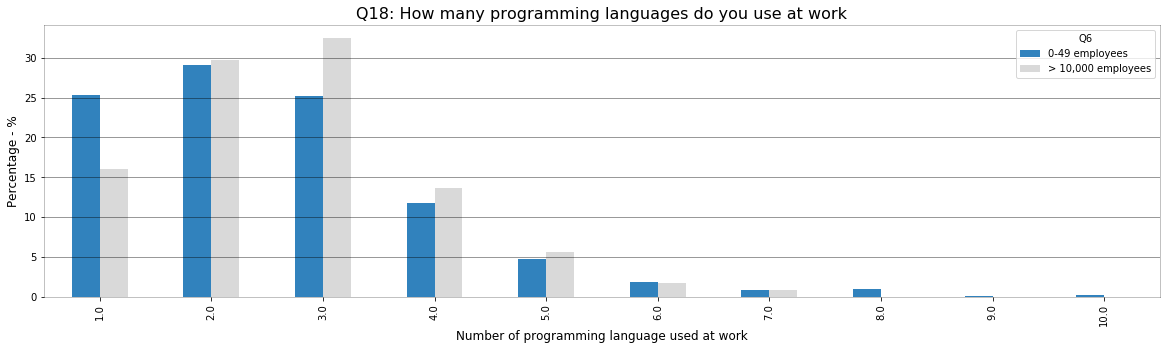

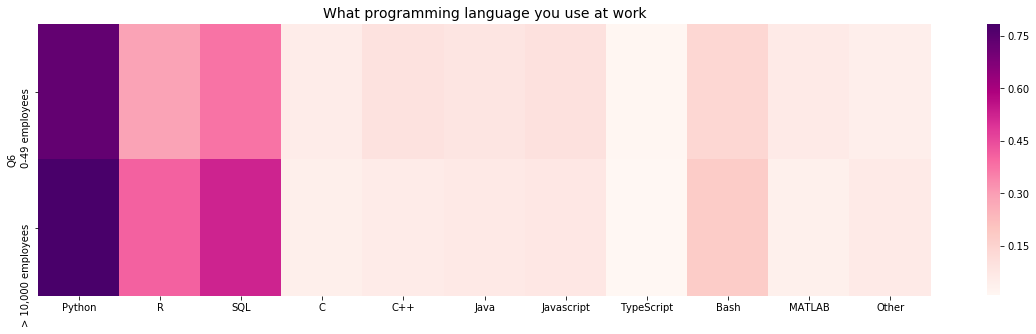

In [16]:
# Question 18
# Data prepration
q18 = df.filter(regex="Q18_Part").dropna(axis=1, how="all").dropna(axis=0, how="all")
q18.columns = [q18[col].dropna().unique()[0] for col in q18]
sum_q18 = pd.Series(q18.notnull().astype(int).sum(axis=1), name="sumed")

# First bar plot
concat_df_bar_plot(df, sum_q18)

for spine in plt.gca().spines.values():
    spine.set_alpha(0.3)
plt.title("Q18: How many programming languages do you use at work", fontsize=16)
plt.grid(axis="y", color="black", alpha=0.5)
plt.xlabel("Number of programming language used at work", fontsize=12)
plt.ylabel("Percentage - %", fontsize=12);

# Heatmap plot
concat_df = pd.concat([df['Q6'], q18.notnull().astype(int)], axis=1)
transformed_df = (concat_df.groupby("Q6").sum().div([STARTUP_NUM, BIG_CORP_NUM], axis=0))
    
plt.figure(figsize=(20, 5))
sns.heatmap(transformed_df, cmap="RdPu")
plt.title("What programming language you use at work", fontsize=14);

## 2.1.5 General Comparison from other perspectives
Here I take a quick glimpse at ML algorithms, tools, frameworks and cloud platforms data scientists use at work to see if there are differences between big firms and early stage startups.

#### Key takeaways:
1. Looking at the most frequently used terms, **overall there is no obvious difference**.
2. From figures illustrating Q24 and Q28, it seems **data scientists in startups are more enthuastic about neural networks and tensorflow/keras (deep learning related)**, this reflects what we saw from Q21 that they use GPUs and TPUs more often. In contrast, **data scientists in big firms seem to use more traditional machine learning and boosting trees**.

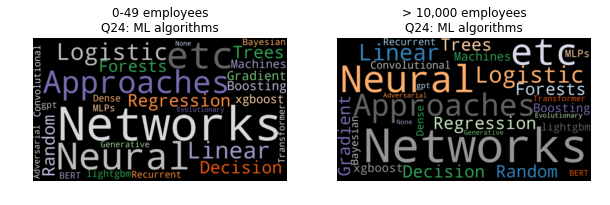

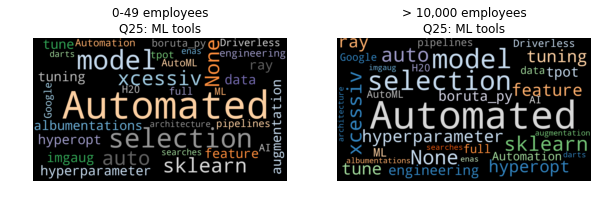

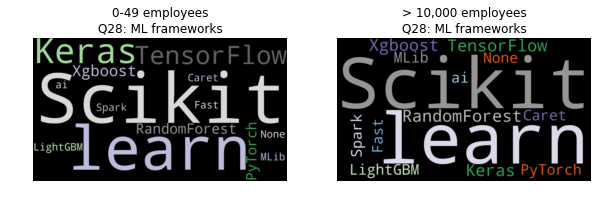

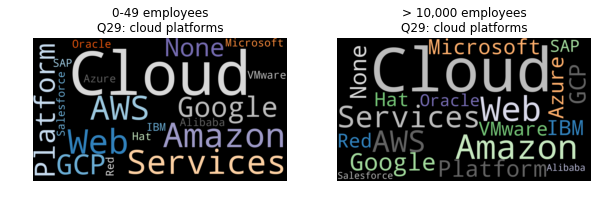

In [17]:
questions = [24, 25, 28, 29]
names = ["Q24: ML algorithms", "Q25: ML tools", "Q28: ML frameworks", "Q29: cloud platforms"]

for n, name in zip(questions, names):
    sub_df = df.filter(regex=f"Q{n}_Part").dropna(axis=1, how="all")
    cats = [sub_df[col].dropna().unique()[0] for col in sub_df]
    sub_df.columns = cats

    concat_df = pd.concat([df["Q6"], sub_df.notnull().astype(int)],
                          axis=1).groupby("Q6")[cats].sum().T

    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10, 10))
    
    i =1
    for col in concat_df:
        txt = ",".join(concat_df[col].sort_values(ascending=False).index)
        plt.subplot(2, 2, i)
        wc = WordCloud(colormap="tab20c", width=1600, height=900).generate(txt)
        plt.imshow(wc, interpolation='bilinear')
        plt.title(col + "\n" + f"{name}")
        plt.axis("off")
        i += 1

## 2.2 What can you expect from big companies and early stage startups?

In this part, I would like to discuss the following aspects in big companies vs early-stage start-ups:

* Age and gender
* Team size
* Salary
* Money spent on ML or Cloud products
* Data science development stage
* Main activities
* Hardwares used at work

## 2.2.1 Age and Gender

Given this is an analysis about data scientists, and currently males are still the majority in this field, as showed in the figure below. However, we could still see more diversity especially in the younger groups, therefore, we could have faith that in a foreseeable future, more and more females would join the data science field.

#### Key takeaways:
1. As you might already expect, startups are quite welcomed among young data scientists, with **30% people working for startups are younger than 25**.
2. Giant companies have more people in their golden ages (25-40), and this might also mean that people with more experience tend to work for big companies.
3. **In startups, you might see higher percentage of young female data scientists** compared to that in big firms, while we barely observe female data scientists (age 45+) in small startups.
4. In small startups, there are more data scientists at their age after 45.

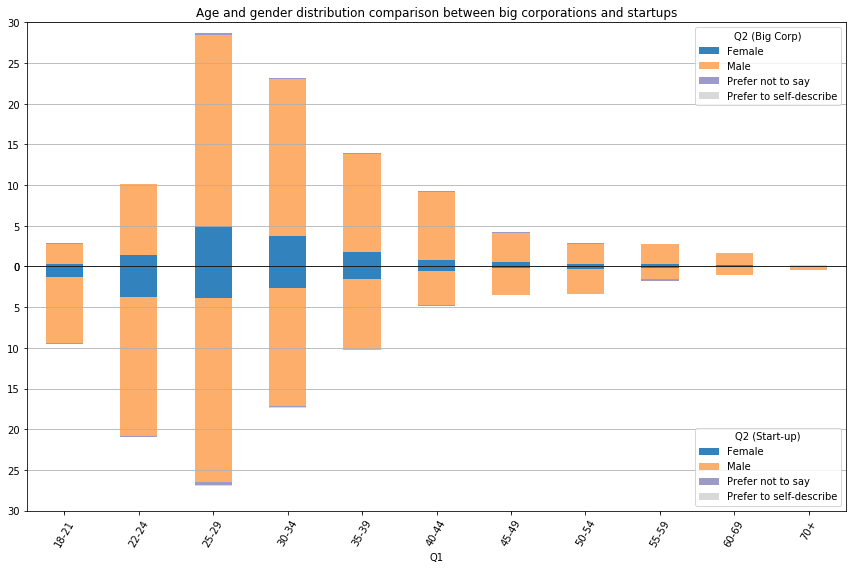

In [18]:
startup_df = _transform_df_q2(df, col="0-49 employees", col_name="Q2 (Start-up)")
big_corp_df = _transform_df_q2(df, col="> 10,000 employees", col_name="Q2 (Big Corp)")

kwargs = {
    "kind": "bar",
    "figsize": (12, 8),
    "legend": True,
    "ylim": (0, 30),
    "stacked": True,
    "cmap": "tab20c"
}

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

big_corp_df.plot(ax=ax1, 
                 title="Age and gender distribution comparison between big corporations and startups", 
                 **kwargs)
startup_df.plot(ax=ax2, **kwargs)

ax1.grid(axis='y')
ax2.grid(axis='y')
ax2.invert_yaxis()

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.xticks(rotation=60)
plt.show()

## 2.2.2 Team size
The overall result is not very surprising, although I only queried survey data for people who filled in their occupation as data scientist.

Note: I filtered out those respondents who did not select any of them, and leave all options blank.

#### Key takeaways:
1. Apparently, due to the difference in the size of the entire company, we could expect that large companies have more people responsible for data science than startups.
2. In startups, **40% of startups have only 1-2 people responsible for data science work**, so it might mean they are likely in the stage of experimenting or people in the team need to be full stack to handle the whole pipeline.
3. From the figure below, we could see almost **25% of startup have more than 5 people** (some startups even have more than 20 people) working around data, given the fact that the size of startups in this analysis is less than 50, it means some small startups are recognizing the value of data science.

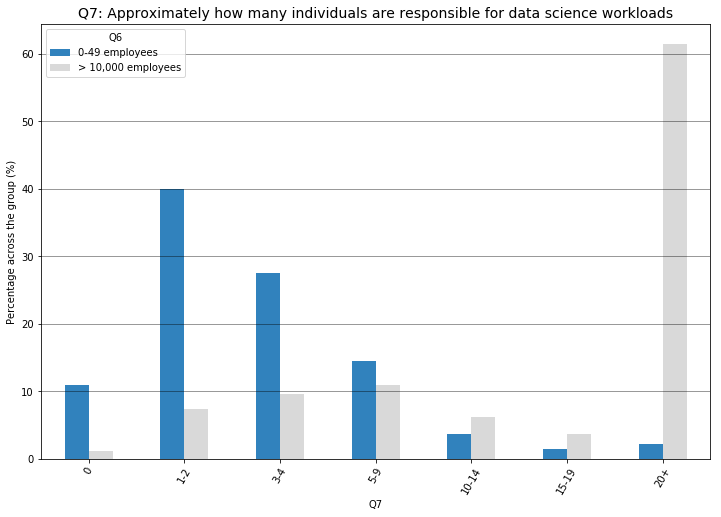

In [19]:
# Question 7
year_idx = ["0", "1-2", "3-4", "5-9", "10-14", "15-19", "20+"]

customized_multi_bar_plot(df, col="Q7", xticks=year_idx, 
                          title="Q7: Approximately how many individuals are responsible for data science workloads")

## 2.2.3 Salary

Here might be very interesting to lots of people. Although it is quite a common sense that big firms usually offer better salary than startups, let us use data to prove it.

#### Key takeaways:

1. There is very significant difference in salary. Although we could guess that some might be interns or due to respondents from different regions/countries, it is still obvious that big companies are paying much better. We all agree that paying well to employees are measuremets big companies usually take to lure talented people, the same applies to data scientists.
2. Globally most of pay scale falls on the range from **10,000 to 200,000 dollars**. 25% of data scientists from big firms have the salaray ranging from 100,000 to 200,000 dollars, and this is quite impressive pay.
3. We might get some interesting insight if we break down countries and see salary level across countries, but because this is not the topic my analysis is focusing, I will not further investigate in it.

In [20]:
# Question 10
ordered_cols = ['$0-999', '1,000-1,999', '2,000-2,999', '3,000-3,999','4,000-4,999',
                '5,000-7,499', '7,500-9,999', '10,000-14,999','15,000-19,999',
                '20,000-24,999', '25,000-29,999', '30,000-39,999', '40,000-49,999', 
                '50,000-59,999', '60,000-69,999', '70,000-79,999', '80,000-89,999', 
                '90,000-99,999', '100,000-124,999', '125,000-149,999', '150,000-199,999', 
                '200,000-249,999', '250,000-299,999', '300,000-500,000', '> $500,000']

q10 = _normalized_value_counts(df, "Q10", reindexed=ordered_cols)
q10.index.name = "Annual Salary($)"
q10.style.format("{:.0%}").background_gradient(cmap="RdPu", axis=0)

Q6,0-49 employees,"> 10,000 employees"
Annual Salary($),,
$0-999,20%,4%
"1,000-1,999",6%,2%
"2,000-2,999",4%,1%
"3,000-3,999",2%,1%
"4,000-4,999",1%,2%
"5,000-7,499",4%,2%
"7,500-9,999",4%,2%
"10,000-14,999",7%,7%
"15,000-19,999",3%,3%


## 2.2.4 Money Spent on Learning ML/Cloud products
Besides the straightforwad impression on salary, we might could also use the money spent on ML/Cloud products to leverage/guess the employee benefit or to see if cloud products are burning money?

One thing to point out is, this is the money spent in the past 5 years, so even the respondents are in the big firms, it does not mean they all stay in the same firm in this time frame.

#### Key takeaways:
1. Data scientists in **big firms also spend more on learning ML/cloud products at work** in the past 5 years.
2. **This is an era to learn and use for free**! As we can see below, 30% data scientists from big firms and 40% of data scientists from small startups spend only less than 100 dollars on ML/Cloud products in the past 5 years. What does it mean? It might mean currently, a large group of data scientists prefer to use online free materials/tools/github/courses to work and learn new things. And this is also good for the community, since it could lower the threshold and open the window for most of people who are interested in jumping into data science field.
3. Are ML/Cloud products expensive? **25% of data scientists from big firms have spent more than 100,000 dollars at work in the past five years**! Wow! This is definitely a big number!
4. Will the expense on the cloud/ML products limit the startups to grow and increase the gap between big firms? We know startups generally get difficulty in affording consistently expensive costs, and we could see only 15% of respondents from startups spent more than 10,000 dollars, while this number from big firms is nearly 40%.

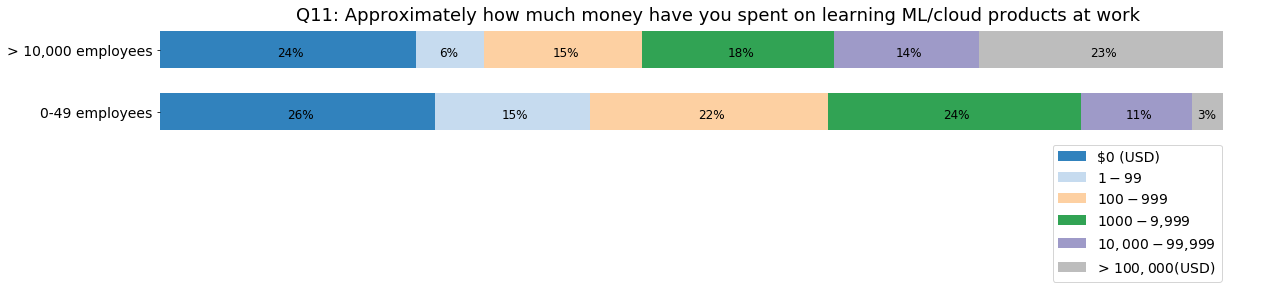

In [21]:
# Question 11
q11 = _normalized_value_counts(df, "Q11")
cmap = plt.get_cmap("tab20c")
colors = cmap(np.array([0, 3, 7, 8, 13, 18]))
ordered_cols = ['$0 (USD)', '$1-$99', '$100-$999', '$1000-$9,999', '$10,000-$99,999', '> $100,000 ($USD)']

customized_barh(q11, 
                colors=colors, 
                ordered_cols=ordered_cols, 
                legend_loc=(0.8, -1.35), 
                title="Q11: Approximately how much money have you spent on learning ML/cloud products at work")

## 2.2.5 Data Science Development
A lot of people might have the doubts on what is the status of current data science development in companies. Since they know it is cool and popular, but do not have any idea about the business adoption. So the Q8 asks how the companies incorporate ML methods into business.

#### Key takeaways:
1. ML methods get more business adoptions in big companies than in small startups.
2. Very excited to see more than **70% respondents from big companies and almost 50% respondents from small startups say they already have models in production**.
3. **Big companies tend to have models in production for benefits**, while almost 40% data scientists from startups are exploring ML and generating insights.
4. **Using ML methods in business is popular**! 85% from big companies are establishing ML methods in production or generating insight, while this number from startups is 65%!

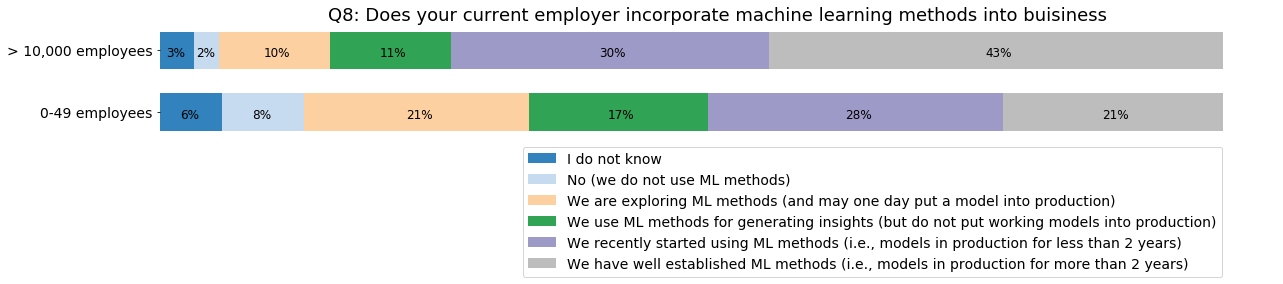

In [22]:
# Question 8
q8 = _normalized_value_counts(df, col="Q8")
cmap = plt.get_cmap("tab20c")
colors = cmap(np.array([0, 3, 7, 8, 13, 18]))
ordered_cols = ['I do not know', 'No (we do not use ML methods)',
 'We are exploring ML methods (and may one day put a model into production)',
 'We use ML methods for generating insights (but do not put working models into production)',
 'We recently started using ML methods (i.e., models in production for less than 2 years)',
 'We have well established ML methods (i.e., models in production for more than 2 years)']

customized_barh(q8, 
                ordered_cols=ordered_cols,
                colors=colors,
                legend_loc=(0.325, -1.3), 
                title="Q8: Does your current employer incorporate machine learning methods into buisiness")


## 2.2.6 Main activities at work

It is pleased to know ML has got a lot of business adpotions, it would be also interesting to know data scientists' main activities at work, and to see if they differ between startups and big firms.

Note: I filtered out those respondents who did not select any of them, and leave all options blank.

#### Key takeaways:
1. Data Scientists from big firms are generally invovled in more types of activities than data scientists from startups.
2. **Analyzing and understanding data and building prototypes are essential**, these two activities make up 50% of data scientists' work in small startups while 70% in big companies.
3. The second takeaway is also aligned with the buinsess adoption of ML we see from last section, because **most companies are at early stage of development of ML**, therefore, main activities are understanding data and building prototypes.
4. It is common that **models get redeveloped and improved**, as we see more than 50% of data scientists from big firms and 40% scientists from small startups are improving existing models.

,Analyze and understand data to influence product or business decisions,"Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data",Build prototypes to explore applying machine learning to new areas,Build and/or run a machine learning service that operationally improves my product or workflows,Experimentation and iteration to improve existing ML models,Do research that advances the state of the art of machine learning,None of these activities are an important part of my role at work,Other
Q6,,,,,,,,
0-49 employees,54.0%,33.5%,48.5%,37.8%,40.2%,23.3%,0.5%,1.5%
"> 10,000 employees",69.7%,35.4%,66.4%,48.1%,51.8%,26.9%,0.8%,1.0%


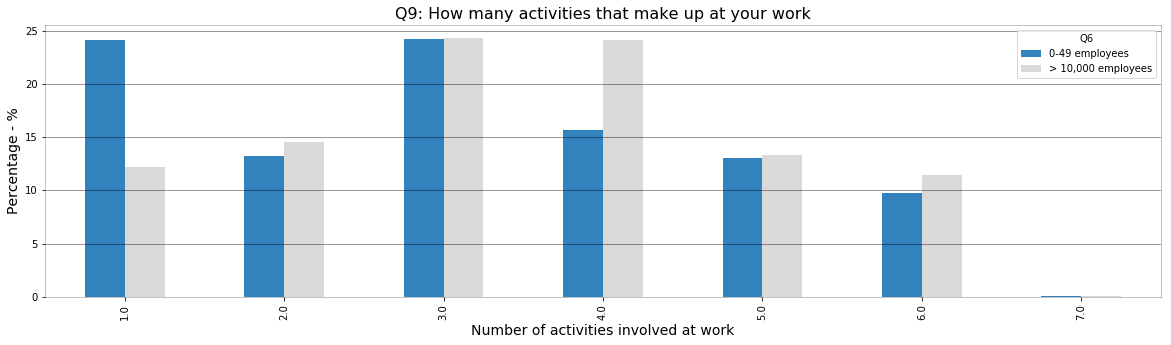

In [23]:
# Question 9
q9 = df.filter(regex="Q9_Part").dropna(axis=1, how="all").dropna(axis=0, how="all")
q9.columns = [q9[col].dropna().unique()[0] for col in q9]
sum_q9 = pd.Series(q9.notnull().astype(int).sum(axis=1), name="sumed")

# bar plot
concat_df_bar_plot(df, sum_q9)

for spine in plt.gca().spines.values():
    spine.set_alpha(0.3)
plt.title("Q9: How many activities that make up at your work", fontsize=16)
plt.grid(axis='y', color="black", alpha=0.5)
plt.xlabel("Number of activities involved at work", fontsize=14)
plt.ylabel("Percentage - %", fontsize=14);


q9 = df.filter(regex="Q9_Part_")
q9_cols = [q9[col].dropna().unique()[0] for col in q9]
q9 = q9.applymap(lambda x: 0 if x is np.nan else 1)
q9.columns = q9_cols

q9_agg = (
    pd.concat([df["Q6"], q9], axis=1)
    .groupby("Q6")[q9_cols]
    .sum()
    .div([STARTUP_NUM, BIG_CORP_NUM], axis=0)
)
# pandas dataframe styler
cm = sns.light_palette("blue", as_cmap=True)
q9_agg.style.format("{:.1%}").background_gradient(cmap="RdPu", axis=1)

## 2.2.7 Hardwares
As we all know, running and experiementing deep learning models usually require very powerful machines. Are people using GPUs or even TPUs at work? Let us find out.

Note: I filtered out those respondents who did not select any of them, and leave all options blank.

#### Key takeaways:
1. Most of data scientists are still using mainly CPUs at work. So **having enough CPUs could satisfy most of people's needs**.
2. GPUs and TPUs are more often used at startups, one possibility could be, GPUs and TPUs are mostly needed in running deep learning models, thus we might get an impression from this result that startups are more active in exploring and trying to develop and apply deep leanring techniques.

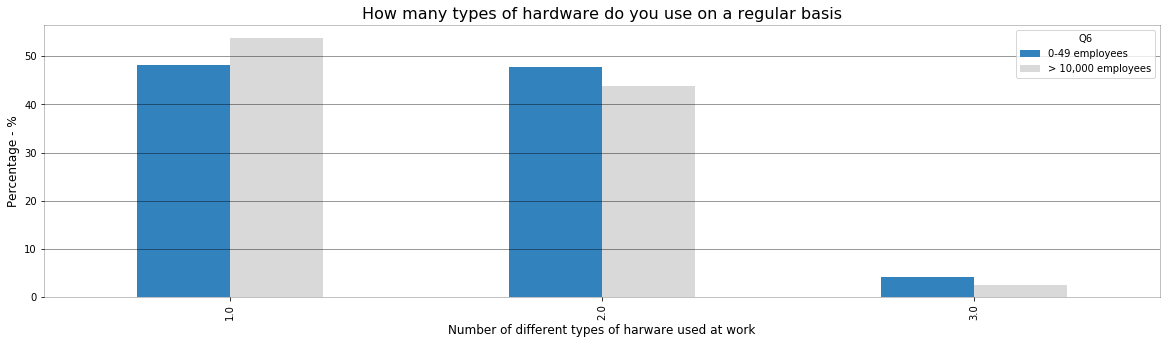

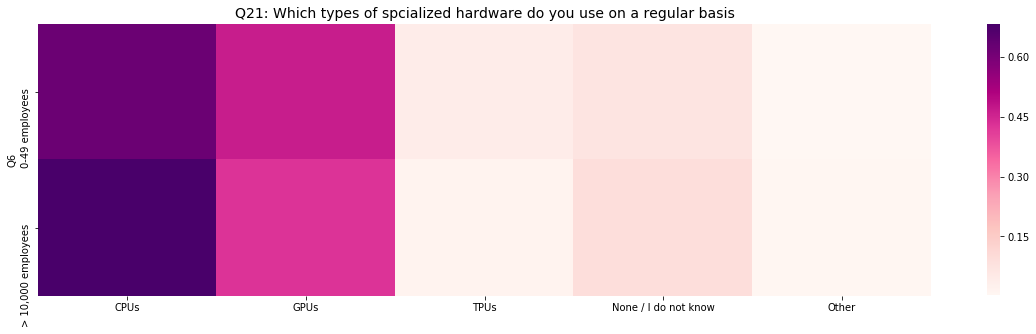

In [24]:
# Question 21
q21 = df.filter(regex="Q21_Part").dropna(axis=1, how="all").dropna(axis=0, how="all")
q21.columns = [q21[col].dropna().unique()[0] for col in q21]
sum_q21 = pd.Series(q21.notnull().astype(int).sum(axis=1), name="sumed")

# bar plot
concat_df_bar_plot(df, sum_q21)

for spine in plt.gca().spines.values():
    spine.set_alpha(0.3)
plt.title("How many types of hardware do you use on a regular basis", fontsize=16)
plt.xlabel("Number of different types of harware used at work", fontsize=12)
plt.grid(axis="y", color="black", alpha=0.5)
plt.ylabel("Percentage - %", fontsize=12);


# Heatmap plot
concat_df = pd.concat([df['Q6'], q21.notnull().astype(int)], axis=1)
transformed_df = (concat_df.groupby("Q6").sum().div([STARTUP_NUM, BIG_CORP_NUM], axis=0))
   
plt.figure(figsize=(20, 5))
sns.heatmap(transformed_df, cmap="RdPu")
plt.title("Q21: Which types of spcialized hardware do you use on a regular basis", fontsize=14);

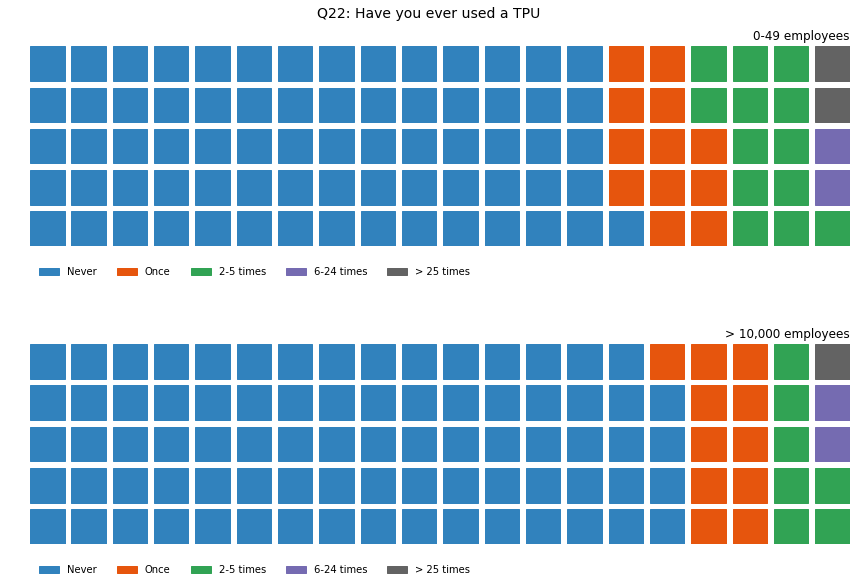

In [25]:
reordered_cols = ['Never', 'Once', '2-5 times', '6-24 times', '> 25 times']
q22 = _normalized_value_counts(df, col="Q22", reindexed=reordered_cols)
q22 = q22.applymap(lambda x: round(x * 100))

n_cat = q22.shape[0]
colors = [plt.cm.tab20c(i/n_cat) for i in range(n_cat)]

fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    plots={
        "211": {
            'values': q22['0-49 employees'].to_dict(),
            'title': {"label": "0-49 employees", "loc": "right"}
        },
        "212": {
            'values': q22['> 10,000 employees'].to_dict(),
            'title': {"label": "> 10,000 employees", "loc": "right"}
        }
    },
    colors=colors,
    figsize=(12, 10),
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.2), 'ncol': n_cat, 'framealpha': 0}
)
plt.suptitle("Q22: Have you ever used a TPU", x=0.5, y=0.9, fontsize=14);

## 3. Clustering Experiment and Correlation Analysis
So far, I have used some visualizations to illustrute the difference in several aspects between data scientists in big firms versus in small startups. Then a question coming to my mind is, what if I apply the unsupervised clustering algorithm on the features I used for analysis and see if there is a clearly pattern between these two groups.

Suprisingly, with the selected features, we do see quite nice segmentation and the new clusters are similar to the clusters by those two groups (0-49 employees and >10000 employees)!! In the new segment 1, nearly 85% of them are from small startups, while in the new segment 0, around 85% are working for big companies. This partly means, this segmentation is indeed aligned with our analysis on those features, and they indeed behave similar in a way.

And I also calculate the correlation between the company size and the features I have used above to see which one has the most significant impacts on it. And the result is similar to what we see from figures themselves. The salary, money spent on ML/cloud tools, and team size are very obvious features. And one other thing to know is, how far is the business adoption in the company is very impactful factor!

In [26]:
def filter_df(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """Filter the needed columns and binarize them."""
    df = df.copy()
    sub_df = df.filter(regex=f"{col}_Part")
    return sub_df.applymap(lambda x: 1 if x is not np.nan else 0)

In [27]:
# Binarize the columns
q9 = filter_df(df, "Q9")
q18 = filter_df(df, "Q18")
q21 = filter_df(df, "Q21")

# For those columns, only get_dummies is enough
cols = ["Q1", "Q2", "Q4", "Q6", "Q7", "Q8", "Q10", "Q11", "Q14", "Q15", "Q19", "Q22", "Q23"]
df_cats = pd.get_dummies(df[cols], prefix=cols)

# Concatenate them into dataset as input of clustering
df_cluster = pd.concat([df_cats, q9, q18, q21], axis=1)

# Dimension reduction
pca_50 = PCA(n_components=50, random_state=2019).fit_transform(df_cluster)
tsne_output = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=5000, 
                   random_state=42).fit_transform(pca_50)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2174 samples in 0.007s...
[t-SNE] Computed neighbors for 2174 samples in 0.554s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2174
[t-SNE] Computed conditional probabilities for sample 2000 / 2174
[t-SNE] Computed conditional probabilities for sample 2174 / 2174
[t-SNE] Mean sigma: 1.101414
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.661278
[t-SNE] KL divergence after 5000 iterations: 1.839440


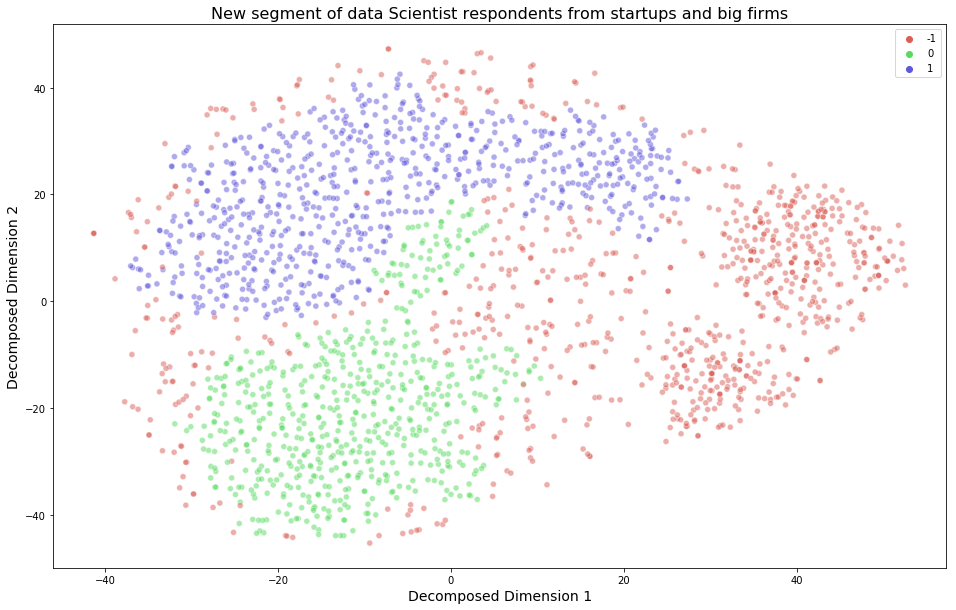

In [28]:
clustered = HDBSCAN(min_cluster_size=500, min_samples=2).fit(tsne_output)
fig = plt.figure(figsize=(16, 10))
plt.title("New segment of data Scientist respondents from startups and big firms", fontsize=16)
sns.scatterplot(tsne_output[:, 0], tsne_output[:, 1], hue=clustered.labels_, legend='full', 
                palette=sns.color_palette('hls', len(np.unique(clustered.labels_))), alpha=0.5)
plt.xlabel("Decomposed Dimension 1", fontsize=14)
plt.ylabel("Decomposed Dimension 2", fontsize=14);

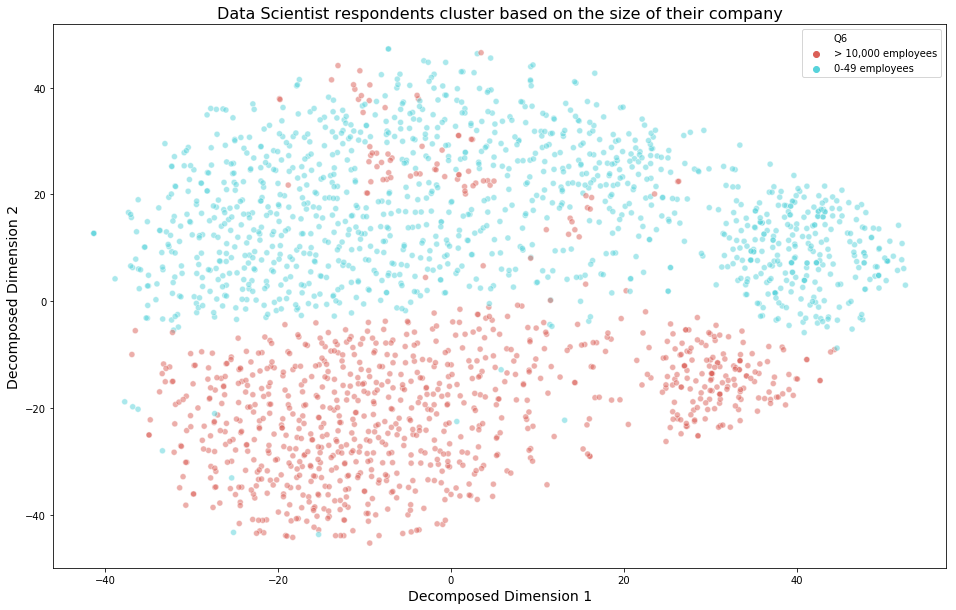

In [29]:
fig = plt.figure(figsize=(16, 10))
plt.title("Data Scientist respondents cluster based on the size of their company", fontsize=16)
sns.scatterplot(tsne_output[:, 0], tsne_output[:, 1], hue=df["Q6"], legend='full', 
                palette=sns.color_palette('hls', 2), alpha=0.5)
plt.xlabel("Decomposed Dimension 1", fontsize=14)
plt.ylabel("Decomposed Dimension 2", fontsize=14);

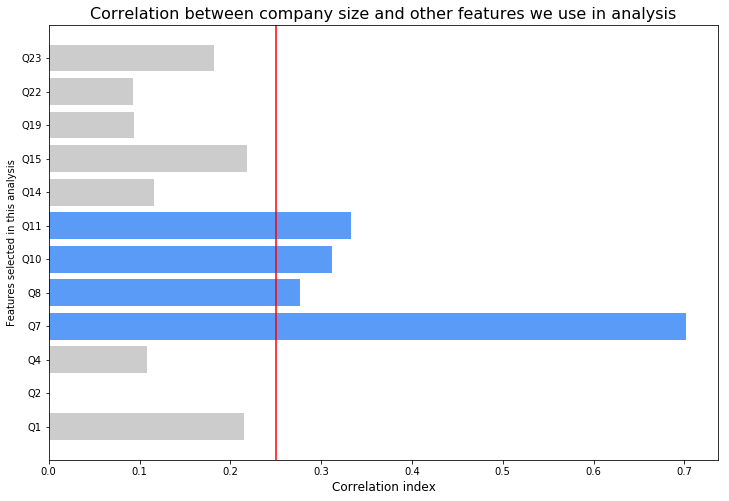

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))

cols = ["Q1", "Q2", "Q4", "Q7", "Q8", "Q10", "Q11", "Q14", "Q15", "Q19", "Q22", "Q23"]
ax.barh(cols, [cramers_v(df['Q6'], df[col]) for col in cols], color="#cccccc")
highs = ["Q7", "Q8", "Q10", "Q11"]
ax.barh(highs, [cramers_v(df['Q6'], df[col]) for col in highs], color="#5a9bf8")
ax.axvline(0.25, color="r")

plt.title("Correlation between company size and other features we use in analysis", fontsize=16)
plt.xlabel("Correlation index", fontsize=12)
plt.ylabel("Features selected in this analysis");

## 4. Overall summary and general recommendations


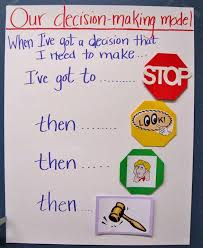

The two questions discussed above represent two main things that people would consider when making a career move. The first one is about the job requirements while the second is about what to expect from the company. As we all know, before making the decision, it is largely dependent on the types of companies and specific jobs. Here I just list several recommendations for different types of (potential) data scientists:

If you are a new graduate who **does not have lots of work experience yet**, according to the survey analysis, applying for small startups might give you a higher chance to be recruited. In addition, due to the coding experience analysis, **having more experience in using code to analyze data** might make you stand out from your peers. Therefore, this could also be an aspect to work on if you want to be an outstanding junior data scientist. If you have a question of which programming language to learn, based on our analysis, **learning Python and SQL** are more aligned with the current trend in data science field, and **knowing good knowledge of Bash** could also stand you out and gain possibility of working for big companies.

If you are an experienced data scientist and have the most skill sets needed in data science, what you consider more would be what companies can provide and what the main activities will be conducted at work:
* Following our analysis on data science development stage, if **you are the person who love to start from scratch and try new topics** (e.g. from exploring and making prototypes to building models and testing in production environment), since **small startups are mostly in early stage of data science development**, you might have a better chance and more autonomy to achieve it in small startups. This is also aligned with people's answers in Quara [3](https://www.quora.com/Whats-the-difference-between-being-a-data-scientist-at-a-large-company-vs-a-startup).
* If you love more research work and would love to focus on area and keep improving it, then we could see that in big companies, you will have higher chances to work on the existing topics and improving it. 
* If you would love to use new **deep learning techniques** and see if you could use it at work, then small companies are more likely to provide this platform for you to explore.
* If you are the person who would like to **lead the team or mentor juniors**, since small companies more likely to have people with relatively less years of experience and also have smaller size of data science team, you would have more chances to develop your leadership or mentorship skill. If you **are keen on learning from your peers and sharing experience and knowledge with each other**, big companies can be a better choice for you, since people there tend to have more experience and multiple skill sets.

Last but not least, there is no good or bad between big companies and small startups, it is all about what you pursue. As long as we keep working hard in the correct direction and improve ourselves, I believe we will all end up in our dream companies and enjoying our work as a data scientist every single day.



### References:
[1] https://blog.madkudu.com/startup-vs-bigco-best-career-option-data-scientists/

[2] https://analyticsindiamag.com/should-you-start-your-data-science-career-with-big-tech-companies-or-startups/

[3] https://www.quora.com/Whats-the-difference-between-being-a-data-scientist-at-a-large-company-vs-a-startup



**Thank you very much for your reading!**